# Optimal Brain Damage

## Intro

* **Gap**: No efficient, theoretically grounded method for pruning that accounts for each weight’s true effect on the loss — prior methods were either crude (magnitude pruning) or computationally prohibitive (brute-force saliency).
* **Improvement**: OBD introduces an efficient, second-order approximation-based pruning method that can safely remove a large fraction of weights while preserving accuracy.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # normalize grayscale images to [-1, 1]
])

train_set = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=256, shuffle=False)

In [23]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) # input channels = 1 (grayscale), output channels = 16, kernel size = 3
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1) # input channels = 16, output channels = 32, kernel size = 3
        self.fc1   = nn.Linear(32 * 7 * 7, 128) # 32 channels, 7x7 feature map after conv2
        self.fc2   = nn.Linear(128, 10) # 10 classes for FashionMNIST

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # Max pooling with kernel size 2
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) 
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallCNN().to(device)

In [24]:
def train(model, optimizer, criterion, epochs=5):
    model.train()
    for _ in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def test(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1) 
            correct += pred.eq(target).sum().item() 
            total += target.size(0)
    return correct / total

In [25]:
def compute_hessian_diag(model, criterion, data_loader, num_batches=1):
    """
    Compute an approximate diagonal of the Hessian of the loss w.r.t. each model parameter.

    Uses the second derivatives of the loss by:
      - Computing gradient of loss (first derivative)
      - Computing gradient of each gradient element sum (second derivative)
    
    Assumes Hessian is diagonal (ignores cross-terms), matching the OBD paper approximation.

    Args:
      model (nn.Module): The neural network model.
      criterion: Loss function.
      data_loader: DataLoader providing (input, target) batches.
      num_batches (int): Number of batches to average over for Hessian estimate.

    Returns:
      List of tensors: Each tensor matches shape of model.parameters() giving Hessian diagonal.
    """
    device = next(model.parameters()).device
    model.eval()

    # Initialize accumulator for Hessian diagonal entries for each param
    hessian_diag = [torch.zeros_like(p, device=device) for p in model.parameters()]
    count = 0

    for data, target in data_loader:
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Compute first derivatives (gradients) w.r.t. model params with create_graph=True to enable further differentiation
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

        # For each parameter, compute second derivative diagonal entries by differentiating sum of grads w.r.t. param
        for i, g in enumerate(grads):
            # g.sum() is scalar; grad of scalar w.r.t param gives vector same shape as param (second derivatives diagonal approx)
            grad2 = torch.autograd.grad(g.sum(), model.parameters(), retain_graph=True)[i]

            # Accumulate Hessian diagonal (detach to avoid memory leak)
            hessian_diag[i] += grad2.detach()

        count += 1
        if count >= num_batches:
            break

    # Average over batches
    for i in range(len(hessian_diag)):
        hessian_diag[i] /= count

    return hessian_diag

In [26]:
def prune_by_obd(model, hessian_diag, prune_fraction, mask_dict):
    saliencies = []
    for (name, param), h_diag in zip(model.named_parameters(), hessian_diag):
        if "weight" in name:
            sal = 0.5 * (param.data ** 2) * h_diag
            saliencies.append(sal.view(-1))

    all_saliencies = torch.cat(saliencies)
    threshold = torch.quantile(all_saliencies, prune_fraction)

    # Update mask
    new_mask_dict = {}
    for (name, param), h_diag in zip(model.named_parameters(), hessian_diag):
        if "weight" in name:
            sal = 0.5 * (param.data ** 2) * h_diag
            mask = (sal > threshold).float()
            if name in mask_dict:
                mask = mask * mask_dict[name]  # Keep previous pruning
            new_mask_dict[name] = mask
        else:
            new_mask_dict[name] = torch.ones_like(param)

    # Apply mask
    with torch.no_grad():
        for name, param in model.named_parameters():
            param.mul_(new_mask_dict[name])

    return new_mask_dict

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Train baseline
train(model, optimizer, criterion, epochs=5)
baseline_acc = test(model)
print(f"Baseline accuracy: {baseline_acc*100:.2f}%")

Baseline accuracy: 88.80%


In [28]:
# Initialize mask dict (all ones initially)
mask_dict = {name: torch.ones_like(param) for name, param in model.named_parameters()}

acc_list = [baseline_acc]
sparsity_list = [0.0]

for prune_iter in range(10):
    # 1. Compute Hessian diag
    h_diag = compute_hessian_diag(model, criterion, train_loader, num_batches=5)

    # 2. Prune lowest-saliency weights
    mask_dict = prune_by_obd(model, h_diag, prune_fraction=0.2, mask_dict=mask_dict)

    # 3. Fine-tune
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    train(model, optimizer, criterion, epochs=3)

    # 4. Eval & track sparsity
    acc = test(model)

    # Count total & remaining parameters
    total_params = sum(p.numel() for name, p in model.named_parameters() if "weight" in name)
    remaining_params = sum(mask.sum().item() for name, mask in mask_dict.items() if "weight" in name)

    sparsity = 1 - (remaining_params / total_params)

    acc_list.append(acc)
    sparsity_list.append(sparsity)
    print(f"Iter {prune_iter}: Acc={acc*100:.2f}%, Sparsity={sparsity*100:.2f}%, Remaining params={remaining_params}")

Iter 0: Acc=89.53%, Sparsity=20.00%, Remaining params=165388.0
Iter 1: Acc=89.74%, Sparsity=35.25%, Remaining params=133856.0
Iter 2: Acc=89.58%, Sparsity=44.90%, Remaining params=113914.0
Iter 3: Acc=89.88%, Sparsity=56.15%, Remaining params=90664.0
Iter 4: Acc=90.11%, Sparsity=62.14%, Remaining params=78278.0
Iter 5: Acc=90.41%, Sparsity=64.61%, Remaining params=73168.0
Iter 6: Acc=90.27%, Sparsity=66.99%, Remaining params=68249.0
Iter 7: Acc=90.20%, Sparsity=69.12%, Remaining params=63846.0
Iter 8: Acc=89.57%, Sparsity=87.37%, Remaining params=26101.0
Iter 9: Acc=89.06%, Sparsity=89.98%, Remaining params=20714.0


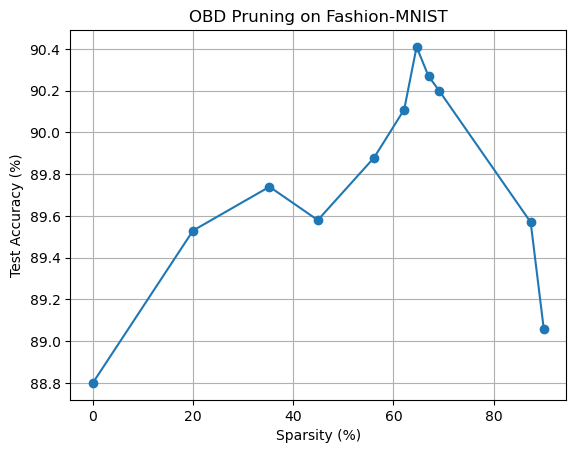

In [31]:
# -------------------
# 7. Plot results
# -------------------
plt.plot([s*100 for s in sparsity_list], [a*100 for a in acc_list], marker='o')
plt.xlabel("Sparsity (%)")
plt.ylabel("Test Accuracy (%)")
plt.title("OBD Pruning on Fashion-MNIST")
plt.grid(True)
plt.show()

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

# Smaller CNN ~20k params
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)   # 8 * 1 * 3 * 3 + 8 = 80 params
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1) # 16 * 8 * 3 * 3 + 16 = 1168 params
        self.fc1 = nn.Linear(16 * 7 * 7, 64)         # 16*7*7*64 + 64 = 50176 params (too big here)
        self.fc2 = nn.Linear(64, 10)                  # 64*10 + 10 = 650 params

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))     # 28x28 -> 14x14
        x = self.pool(torch.relu(self.conv2(x)))     # 14x14 -> 7x7
        x = x.view(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
model = SmallCNN()
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Total parameters: 52138


In [ ]:
# Setup device, criterion, optimizer, loaders (assume these are defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train(model, optimizer, criterion, epochs=5)
acc = test(model)
print(f"Test Accuracy: {acc*100:.2f}%")